* This notebook was made to look at the alongshore, cross-starit transport of fresh water, total water amount of each run.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
)
import datetime, os
from glob import glob
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from R_mixStuff import sites
from R_mixStuff import strings
mpl.rcParams.update({'font.size': 24})
mpl.rcParams["axes.formatter.useoffset"] = False
%matplotlib inline

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

(48.95, 49.4)

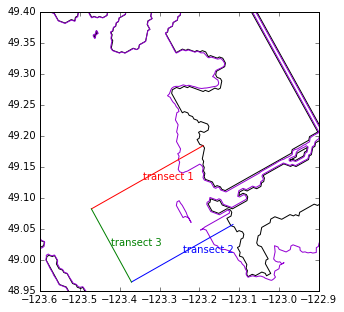

In [4]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.plot(X[55,25:80],Y[55,25:80],'r')
ax.plot(X[25,25:75],Y[25,25:75],'b')
ax.plot(X[25:56,25],Y[25:56,25],'g')
ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
ax.annotate ('transect 2',(X[25,50],Y[25,50]), xycoords="data",color = 'b')
ax.annotate ('transect 3',(X[40,25],Y[40,25]), xycoords="data",color = 'g')
ax.set_xlim([-123.6,-122.9])
ax.set_ylim([48.95,49.4])

In [5]:
## load salinity into a dict
paths = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternT = 'oct2014*_T.nc'
file_patternU = 'oct2014*_U.nc'
file_patternV = 'oct2014*_V.nc'
U = {}; V={}
for pa in paths:
    pathT = glob(os.path.join(base,pa, file_patternT))
    pathU = glob(os.path.join(base,pa, file_patternU))
    pathV = glob(os.path.join(base,pa, file_patternV))
    fU = nc.Dataset(pathU[0],'r');
    U[pa] = fU.variables['vozocrtx']
    fV = nc.Dataset(pathV[0],'r');
    V[pa] = fV.variables['vomecrty']
    depU = fU.variables['depthu']
    depV = fV.variables['depthv']
    fT = nc.Dataset(pathT[0],'r');
    lon = fT.variables['nav_lon'] 
    lat = fT.variables['nav_lat'] 

In [6]:
def transport_time (U,V,lon,lat,tran,string ='specific time'):
    """This subfunction was made only to calculate the 
        transport/freshwater transport of a transect at the specific time"""
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3': ## cross-shelf transport
        for pa in paths:
            trans[pa] = {};
            for t in strings[string]:
                trans[pa][t] = np.zeros([depU.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']-1).shape[0]])
                for z in np.arange(depU.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']-1):
                        d = tidetools.haversine(lon[transects[tran]['jst']+j,transects[tran]['ist']],\
                        lat[transects[tran]['jst']+j,transects[tran]['ist']], \
                        lon[transects[tran]['jst']+j+1,transects[tran]['ist']],\
                        lat[transects[tran]['jst']+j+1,transects[tran]['ist']])
                        trans[pa][t][z,j] = U[pa][t][z,j,0]*d*1000
    else: ## along-shore transport
        for pa in paths:
            trans[pa] = {};
            for t in strings[string]:
                trans[pa][t] = np.zeros([depV.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']-1).shape[0]]);
                for z in np.arange(depV.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']-1):
                        d = tidetools.haversine(lon[transects[tran]['jst'],transects[tran]['ist']+i],\
                        lat[transects[tran]['jst'],transects[tran]['ist']+i], \
                        lon[transects[tran]['jst'],transects[tran]['ist']+i+1],\
                        lat[transects[tran]['jst'],transects[tran]['ist']+i+1])
                        trans[pa][t][z,i] = V[pa][t][z,0,i]*d*1000 ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = {}; trans_total[pa] ={}
        for t in strings[string]:
            trans_surf[pa][t] = np.sum(trans[pa][t],axis = 1)[0]
            trans_total[pa][t] = np.sum(trans[pa][t])
 
    return trans, trans_surf,trans_total

In [11]:
def transport_calculate (U,V,lon,lat,tran,string ='specific time',fresh_flag = False,y0lim =80000, y1lim = 6000):
    """ This function was made to calculate the total transport (False)
        or fresh water transport (True) in the entire water column at specific 
        time or averaged low/high tides along the north/south cross-strait
        transect or along-shore transect .
    """
    fig = plt.figure(figsize=(20,12))
    gs = gridspec.GridSpec(2, 2,width_ratios=[1,2], height_ratios=[1, 1])  
    gs.update(hspace=0.15, wspace=0.15)
    UU = {}; VV= {};
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    if string == 'specific time':
        for pa in paths:
            UU[pa] = {}; VV[pa] = {}
        for t in strings[string]:
            for pa in paths:
                u,v = viz_tools.unstagger(U[pa][strings[string][t],:,jinds,iinds],\
                                          V[pa][strings[string][t],:,jinds,iinds])
                #rotate
                theta = np.pi*29/180
                UU[pa][t] = u*np.cos(theta) - v*np.sin(theta)
                VV[pa][t] = u*np.sin(theta) +v*np.cos(theta)
        trans,trans_sur,trans_to = transport_time(UU,VV,lon,lat,tran) ## get surface/total transport
        ## location
        ax = fig.add_subplot(gs[0,0])
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
        ax.set_xlim([-123.6,-122.9])
        ax.set_ylim([48.95,49.4])
        if tran =='3':
            ax.plot(X[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']],\
            Y[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']],'r')
        else:
            ax.plot(X[transects[tran]['jst'],transects[tran]['ist']:transects[tran]['ien']],\
            Y[transects[tran]['jst'],transects[tran]['ist']:transects[tran]['ien']],'r')
        ax.annotate ('transect '+tran,(X[transects[tran]['jst'],transects[tran]['ist']],\
                    Y[transects[tran]['jst'],transects[tran]['ist']]), xycoords="data",color = 'r')
        ## total transport
        ax = fig.add_subplot(gs[0,1])
        cs = ['g','r','m','k','y']
        transurf = {}; trantotal = {} ## turn a dict to list
        for pa in paths:
            transurf[pa] = []; trantotal[pa] = [];
            for t in strings[string]:
                surf = trans_sur[pa][t] 
                transurf[pa].append(surf) 
                tot = trans_to[pa][t]
                trantotal[pa].append(tot)
                
        for pa,c in zip(paths,cs):
            ax.plot(trantotal[pa],'-*',color = c,label = pa)
        ax.set_ylim([-y0lim,y0lim])
        ## surface transport
        ax = fig.add_subplot(gs[1,1]) 
        for pa,c in zip(paths,cs):
            ax.plot(transurf[pa],'-.*',color = c,label = pa)
        ax.set_ylim([-y1lim,y1lim]) 
        for ax in [fig.add_subplot(gs[0,1]),fig.add_subplot(gs[1,1])]:
            ax.legend(loc = 'best')
            ax.grid('on')
            plt.setp(ax, xticks=[0, 1, 2], xticklabels=['low tide','middle of flood','high tide'])
            if fresh_flag == False:
                ax.set_ylabel('Total transport [m^3/s]')
            else:
                ax.set_ylabel('fresh water transport [m^3/s]')
    return fig

# Total transport

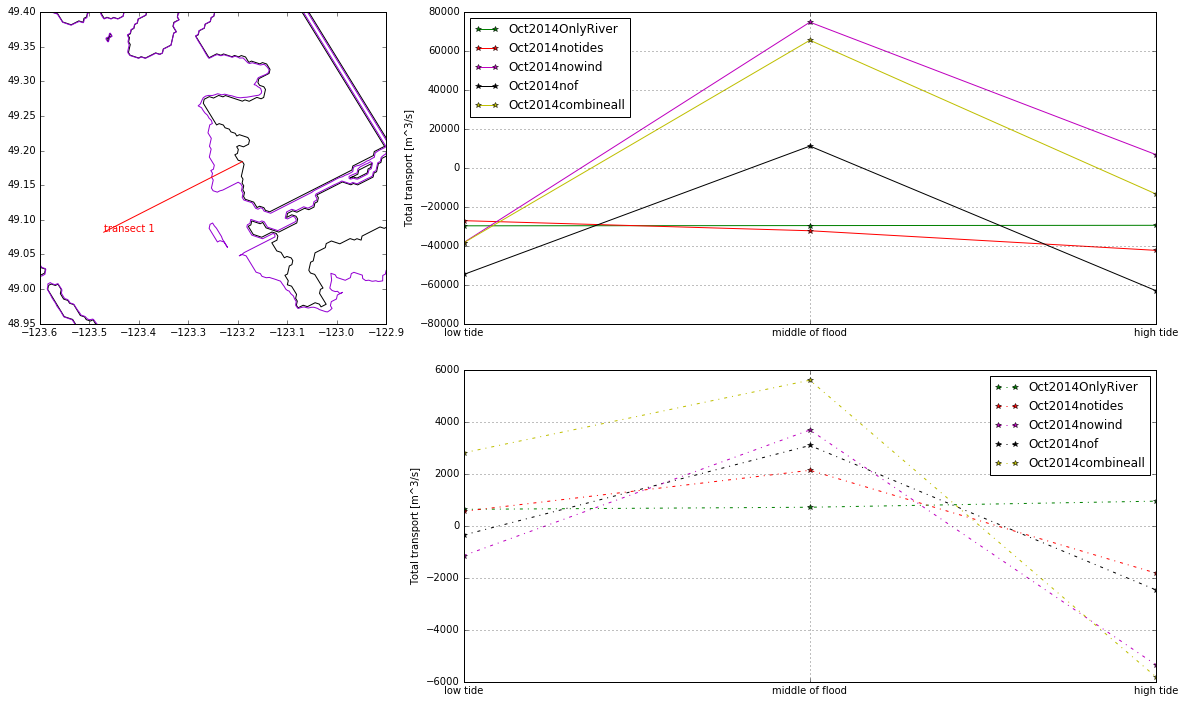

In [12]:
fig = transport_calculate(U,V,lon,lat,'1')

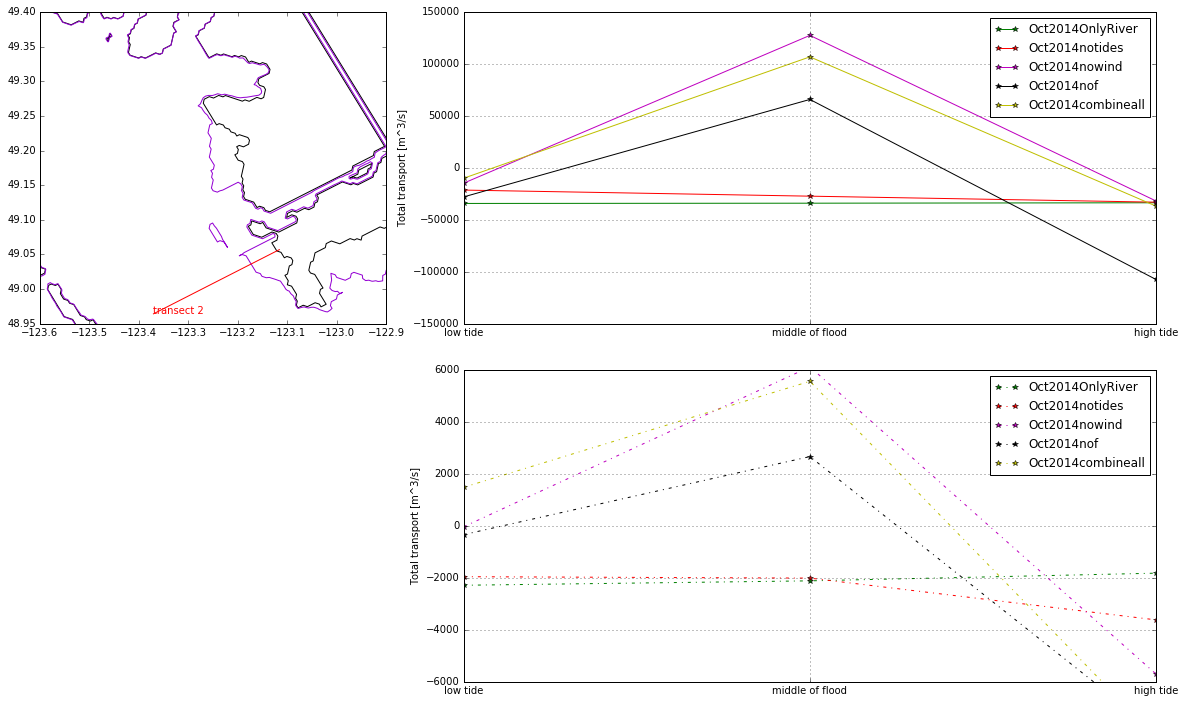

In [14]:
fig = transport_calculate(U,V,lon,lat,'2',y0lim =1.5e5)

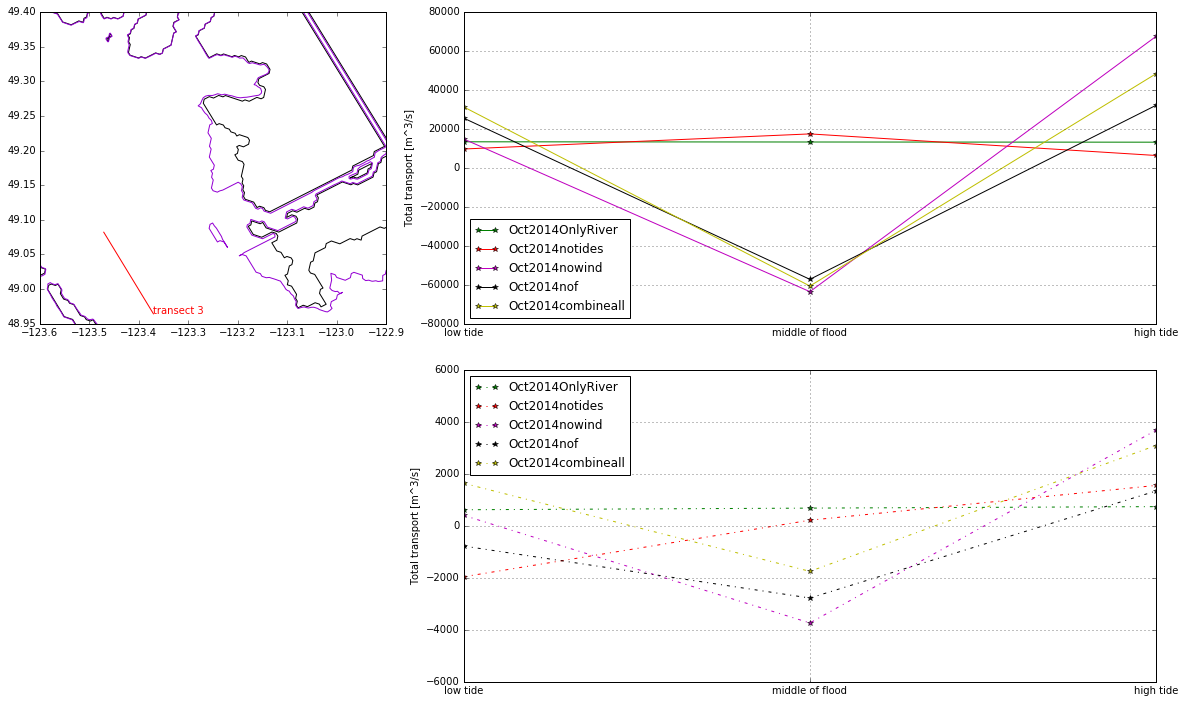

In [15]:
fig= transport_calculate(U,V,lon,lat,'3')

* No wind case does not affect much on the total water transport in the water column of the plume region, more important for downstream surface transport than upstream.
* Total transport at north/south transect of onlyriver/notide case is always upstream, with surface transport going north and south for each transect (north/south), respectively.